<a href="https://colab.research.google.com/github/aniketrajnish/CS499-SDFNet/blob/main/Iteration1_bottles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/
https://www.projectpro.io/recipes/crop-and-resize-image-pytorch
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
# import tensorflow.keras as keras
# import numpy as np
# from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
#!unzip '/content/drive/MyDrive/GraphicsModelRendering/BottleRenders_New.zip' -d '/content/sample_data/new'

In [ ]:
train_file = '/content/drive/MyDrive/GraphicsModelRendering/BottleVars.csv'

train_folder = '/content/drive/MyDrive/GraphicsModelRendering/BottleRenders'

In [ ]:
#train_df['combined'] = np.asarray(train_df[train_df.columns[1:]].values)

In [ ]:
#train_df = train_df.filter(['Bottle', 'combined'])


In [ ]:
# train_gen = ImageDataGenerator(rescale=1./255)
# train_data = train_gen.flow_from_dataframe(dataframe=train_df, directory=train_folder, x_col='Bottle',
#                                            y_col='combined', batch_size=16, shuffle=True,
#                                            class_mode='raw', target_size=(200, 150))

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from skimage import io, transform
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size. Smaller image side is mathced to a given integer.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample[0], sample[1]

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return img,labels


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels = sample[0], sample[1]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(labels)

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        im=Image.open(img_path)
        im=im.convert('RGB')
        image = np.asarray(im)
        labels = self.img_labels.iloc[idx, 1:]
        labels = np.asarray([labels])
        labels = labels.astype('float')
        sample=(image,labels)
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
dataset = CustomImageDataset(train_file,
                                         train_folder,
                                         transforms.Compose([Rescale(300),ToTensor()]))

In [ ]:
batch_size = 16
validation_split = .05
shuffle_dataset = False
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
trainSteps = len(train_loader.dataset) // batch_size
valSteps = len(validation_loader.dataset) // batch_size


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch.nn as nn
from torch import flatten
from torch.optim import Adam
import time
import matplotlib.pyplot as plt

In [ ]:
class My_Model(Module):
  def __init__(self, numChannels, num_classes):
		# call the parent constructor
    super(My_LeNet, self).__init__()
    self.features = nn.Sequential(
            nn.Conv2d(numChannels, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
        )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.dense = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(256 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(2048, num_classes),
            nn.ReLU(inplace=True),
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.dense(x)
    return x

In [ ]:
model = My_Model(
	numChannels=3,
	num_classes=19).to(device)

In [ ]:
INIT_LR = 1e-3
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = torch.nn.L1Loss()

In [ ]:
H = {
	"train_loss": [],
	"val_loss": [],
}


In [ ]:
EPOCHS=8
startTime = time.time()
def my_loss(output, target):
    loss = torch.mean(abs((output - target)/output))
    return loss
for e in range(0, EPOCHS):
  # set the model in training mode
  model.train()
  # initialize the total training and validation loss
  totalTrainLoss = 0
  totalValLoss = 0
  # initialize the number of correct predictions in the training
  # and validation step
  trainCorrect = 0
  valCorrect = 0
	# loop over the training set
  
  loss=torch.zeros([1], dtype=torch.float32, device=device)
  for (x, y) in train_loader:
    # send the input to the device
    (x, y) = (x.to(device), y.to(device))
    # perform a forward pass and calculate the training loss
    x=x.type(torch.float)
    y=y.type(torch.float)
    pred = model(x)
    loss=my_loss(pred,y)
    # zero out the gradients, perform the backpropagation step,
    # and update the weights
    opt.zero_grad()
    loss.backward()
    opt.step()
    # add the loss to the total training loss so far and
    # calculate the number of correct predictions
    totalTrainLoss += loss
    
  with torch.no_grad():
		# set the model in evaluation mode
    model.eval()
    # loop over the validation set
    for (x, y) in validation_loader:
      # send the input to the device
      
      (x, y) = (x.to(device), y.to(device))
      # make the predictions and calculate the validation loss
      x=x.type(torch.float)
      pred = model(x)
      print(pred)
      totalValLoss += (lossFn(pred, y)*19)
      
  avgTrainLoss = totalTrainLoss / trainSteps
  avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
  trainCorrect = trainCorrect / len(train_loader.dataset)
  valCorrect = valCorrect / len(validation_loader.dataset)
  # update our training history
  H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["val_loss"].append(avgValLoss.cpu().detach().numpy())
  # print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))

endTime = time.time()

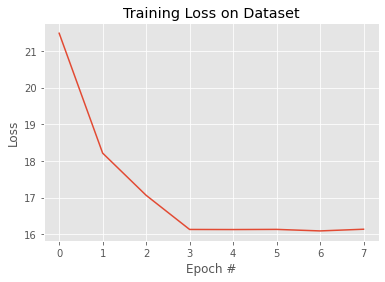

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
#plt.plot(H["val_loss"], label="val_loss")

plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

In [ ]:
# import torchvision.transforms.functional as fn
# img_path='/content/drive/MyDrive/GraphicsModelRendering/BottleRenders/Bottle1.png'
# im=Image.open(img_path)
# im=im.convert('RGB')
# width, height = im.size
# im.show()
# # Setting the points for cropped image
# left = 320
# top = 0
# right = 560
# bottom = 2.6 * height / 4
 
# # Cropped image of above dimension
# # (It will not change original image)
# im1 = im.crop((left, top, right, bottom))
 
# # Shows the image in image viewer
# im1.show()


In [ ]:
# test_dataset = CustomImageDataset(test_file,
#                                          test_folder,
#                                          transforms.Compose([Rescale(150),ToTensor()]))

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/GraphicsModelRendering/alexnet_new.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
